# Tutorial3: GAT implementation

## Outline

- Implementation of GAT

Official resources:
* [Code](https://dsgiitr.com/blogs/gat/)

In [1]:
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F

## Structure

In [2]:
class GATLayer(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    print("forward is passed")

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [3]:
in_features = 5 # inF
out_features = 2 # outF
nb_nodes = 3

#input
X = torch.rand((nb_nodes,in_features)) #(n,inF)

#weights
W = nn.Parameter(data=torch.zeros(size=(out_features,in_features)))
nn.init.xavier_uniform_(W.data) #xavier weights for better training, prevent vanishing/exploding gradient

#linear transformation
h = torch.mm(W,X.T).T

print(h.shape)

torch.Size([3, 2])


### Attention Mechanism

![title](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/AttentionMechanism.png?raw=1)

In [4]:
W_att = nn.Parameter(torch.zeros(2*out_features,1)) # attention weights
nn.init.xavier_uniform_(W_att.data,gain= 1.414)

assert W_att.shape == (2*out_features,1)

l_relu = nn.LeakyReLU(0.2) # leakyRelu
print(l_relu)

LeakyReLU(negative_slope=0.2)


- `view` and `repeat` method
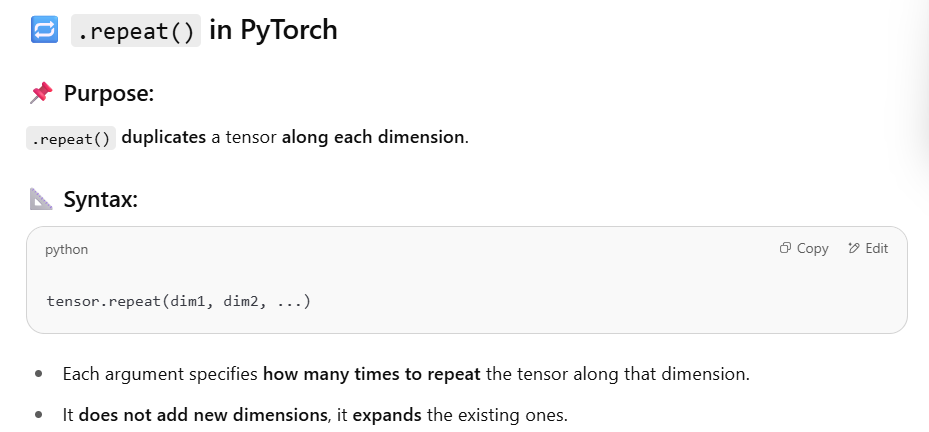
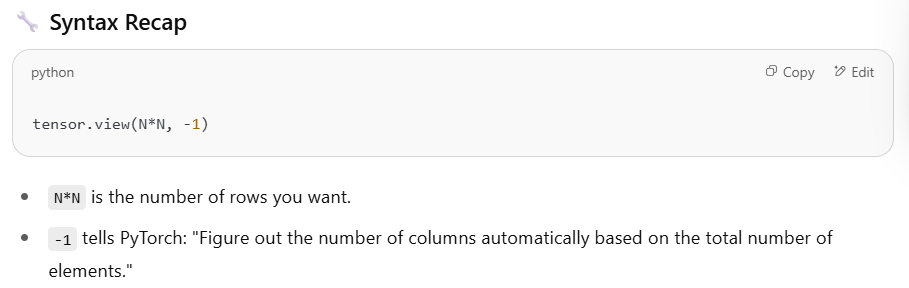

![title](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/a_input.png?raw=1)

In [5]:
N = nb_nodes
print(h)
l = h.repeat(1,N).view(N*N,-1)
r = h.repeat(N,1)
print(l.shape,r.shape)
# print(l,r)

h_hat = torch.cat((l,r),dim=1)
print(h_hat.shape,h_hat)

#attention score
e = l_relu(torch.mm(h_hat,W_att)).view(3,-1)
e.shape

tensor([[ 0.7783,  0.0244],
        [ 0.5946, -0.1877],
        [ 1.0349, -0.4370]], grad_fn=<PermuteBackward0>)
torch.Size([9, 2]) torch.Size([9, 2])
torch.Size([9, 4]) tensor([[ 0.7783,  0.0244,  0.7783,  0.0244],
        [ 0.7783,  0.0244,  0.5946, -0.1877],
        [ 0.7783,  0.0244,  1.0349, -0.4370],
        [ 0.5946, -0.1877,  0.7783,  0.0244],
        [ 0.5946, -0.1877,  0.5946, -0.1877],
        [ 0.5946, -0.1877,  1.0349, -0.4370],
        [ 1.0349, -0.4370,  0.7783,  0.0244],
        [ 1.0349, -0.4370,  0.5946, -0.1877],
        [ 1.0349, -0.4370,  1.0349, -0.4370]], grad_fn=<CatBackward0>)


torch.Size([3, 3])

### Masked Attention

In [6]:
# applying masking(0 --> dont take,1 --> take)
take = torch.randint(low=0,high=2,size=(3,3))
print(take)

zero_vec = -9e15* torch.ones_like(e) # small -ve value(not 0) --> for softmax,e^0 = 1(will give contribution) but for very small num, no contribution
print(zero_vec)

masked_e = torch.where(take>0,e,zero_vec) #for take>0 , use value from e else from zero_vec
print(masked_e.shape)

# masked_e[i,:] is unnormalized score to diff neighbour of i_th node,the attention weights it assigns to its neighbors sum up to 1.
att = F.softmax(masked_e,dim=1)
print(att)

# calculating
h_prime = torch.mm(att,h)
print(h_prime.shape,h.shape)
print(h,"\n",h_prime)

tensor([[1, 0, 1],
        [1, 0, 1],
        [1, 1, 1]])
tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])
torch.Size([3, 3])
tensor([[0.5296, 0.0000, 0.4704],
        [0.5296, 0.0000, 0.4704],
        [0.3454, 0.3478, 0.3068]], grad_fn=<SoftmaxBackward0>)
torch.Size([3, 2]) torch.Size([3, 2])
tensor([[ 0.7783,  0.0244],
        [ 0.5946, -0.1877],
        [ 1.0349, -0.4370]], grad_fn=<PermuteBackward0>) 
 tensor([[ 0.8990, -0.1927],
        [ 0.8990, -0.1927],
        [ 0.7931, -0.1909]], grad_fn=<MmBackward0>)


# Build the layer

In [7]:
class GAT(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.6, concat=True):
        super().__init__()
        self.out_features = out_features
        self.dropout = dropout # drop prob
        self.concat = concat
        self.alpha = alpha #-ve slope for leaky relu

        self.W = nn.Parameter(torch.zeros(size=(out_features, in_features)))
        nn.init.xavier_uniform_(self.W.data)

        self.W_att = nn.Parameter(torch.zeros(2 * out_features, 1))
        nn.init.xavier_uniform_(self.W_att.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, X, adj):
        """
        X: input data (n, d_in)
        """
        n, d_in = X.shape
        assert d_in == self.in_features

        # Linear Transformation
        h = torch.mm(X, self.W.T)

        # Attention Mechanism
        l = h.repeat(1, n).view(n * n, -1)
        r = h.repeat(n, 1)
        h_hat = torch.cat((l, r), dim=1)

        e = self.leakyrelu(torch.mm(h_hat, self.W_att)).view(n, -1)

        zero_vec = -9e15 * torch.ones_like(e)
        masked_e = torch.where(adj > 0, e, zero_vec)

        att = F.softmax(masked_e, dim=1)
        att = F.dropout(att, self.dropout, training=self.training)

        h_prime = torch.mm(att, h)

        return h_prime

# Use it

In [9]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.1 MB/s eta 0:00:00


In [19]:
import torch.nn as nn
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

In [12]:
data_name = "Cora"
dataset = Planetoid(root="data",name = data_name,split="public")
dataset.transform = T.NormalizeFeatures()

print(f"Number of classes: {dataset.num_classes}")
print(f"Number of Node Features: {dataset.num_node_features}")
print(f"Number of Edges Features: {dataset.num_edge_features}")
print(f"Number of Features: {dataset.num_features}")

Number of classes: 7
Number of Node Features: 1433
Number of Edges Features: 0
Number of Features: 1433


In [14]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])